## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import date
import datetime
import time
#import requests

from scipy.stats import poisson

import nba_api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog
from nba_api.stats.endpoints import teamgamelogs
from nba_api.stats.endpoints import teamandplayersvsplayers

import emcee
import corner

import pickle

import seaborn as sns
sns.set()

## Let's pull some team/game info from the NBA API

In [2]:
#2015-2016 regular season start and end dates
start_15_16 = '2015-10-27'
end_15_16 = '2016-04-13'
#2016-2017 regular season start and end dates
start_16_17 = '2016-10-25'
end_16_17 = '2017-04-12'
#2016-2017 regular season start and end dates
start_17_18 = '2017-10-17'
end_17_18 = '2018-04-11'
#2018-2019 regular season start and end dates
start_18_19 = '2018-10-16'
end_18_19 = '2019-04-10'

In [3]:
#dates defining training and testing sets
start_15_16_train = '2015-10-27'
end_15_16_train = '2016-02-1'

start_15_16_test = '2016-02-2'
end_15_16_test = '2016-04-13'

In [4]:
teams_df = pd.DataFrame(teams.get_teams())
teams_df.rename(columns={'id':'TEAM_ID'}, inplace=True)
teams_df.head()

,TEAM_ID,full_name,abbreviation,nickname,city,state,year_founded
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949
1,1610612738,Boston Celtics,BOS,Celtics,Boston,Massachusetts,1946
2,1610612739,Cleveland Cavaliers,CLE,Cavaliers,Cleveland,Ohio,1970
3,1610612740,New Orleans Pelicans,NOP,Pelicans,New Orleans,Louisiana,2002
4,1610612741,Chicago Bulls,CHI,Bulls,Chicago,Illinois,1966


In [5]:
# Get **all** the games so we can filter to an individual GAME_ID
result = leaguegamefinder.LeagueGameFinder()
all_games = result.get_data_frames()[0]
all_games.head()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22019,1612709911,IWA,Iowa Wolves,2021900026,2020-03-15,IWA @ MHU,None,107,41,...,0.833,2,15,17,8,1,7,11,8,-16.2
1,22019,1612709926,MHU,Memphis Hustle,2021900026,2020-03-15,MHU vs. IWA,None,120,56,...,1.000,7,17,24,13,5,1,4,7,15.6
2,22019,1612709914,STO,Stockton Kings,2021900570,2020-03-11,STO vs. OKL,W,241,131,...,0.667,15,29,44,29,9,1,14,20,4.0
3,22019,1610612737,ATL,Atlanta Hawks,0021900969,2020-03-11,ATL vs. NYK,L,265,131,...,0.808,15,38,53,26,6,3,17,25,0.0
4,22019,1610612743,DEN,Denver Nuggets,0021900973,2020-03-11,DEN @ DAL,L,240,97,...,0.625,3,37,40,23,6,4,15,20,-7.8


In [6]:
#match NBA teams from 'teams_df' with 'all_games' to remove
#all non NBA-games from 'all_games' 
nba_games = pd.merge(teams_df, all_games, on = 'TEAM_ID', how = 'inner')
nba_games.head()

,TEAM_ID,full_name,abbreviation,nickname,city,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,TEAM_NAME,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.808,15,38,53,26,6,3,17,25,0.0
1,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.593,12,41,53,33,1,5,15,26,5.0
2,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.857,14,32,46,23,9,2,14,24,-17.0
3,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.667,6,30,36,25,9,4,17,25,-6.0
4,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,Atlanta Hawks,...,0.938,16,27,43,20,6,8,17,21,-39.0


In [7]:
#uses 'total_pts_game' function to create df of sum of final score for
#use pandas to do it faster (thanks Robert!)
total_points = nba_games.groupby("GAME_ID")["PTS"].sum()
nba_games = nba_games.set_index("GAME_ID")
nba_games["COMBINED_FINAL_SCORE"] = total_points
nba_games = nba_games.reset_index()

In [8]:
#appends new column to 'nba_games' df containing combined final score per game
nba_games.head()

,GAME_ID,TEAM_ID,full_name,abbreviation,nickname,city,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,COMBINED_FINAL_SCORE
0,0021900969,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,...,15,38,53,26,6,3,17,25,0.0,267
1,0021900957,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,...,12,41,53,33,1,5,15,26,5.0,281
2,0021900943,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,...,14,32,46,23,9,2,14,24,-17.0,219
3,0021900930,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,...,6,30,36,25,9,4,17,25,-6.0,230
4,0021900905,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22019,ATL,...,16,27,43,20,6,8,17,21,-39.0,215


In [9]:
#mask to filter dates within range
mask_15_16 = (nba_games['GAME_DATE'] >= start_15_16) & (nba_games['GAME_DATE'] <= end_15_16)
mask_16_17 = (nba_games['GAME_DATE'] >= start_16_17) & (nba_games['GAME_DATE'] <= end_16_17)
mask_17_18 = (nba_games['GAME_DATE'] >= start_17_18) & (nba_games['GAME_DATE'] <= end_17_18)
mask_18_19 = (nba_games['GAME_DATE'] >= start_18_19) & (nba_games['GAME_DATE'] <= end_18_19)

In [10]:
mask_15_16_train = (nba_games['GAME_DATE'] >= start_15_16_train) & (nba_games['GAME_DATE'] <= end_15_16_train)
mask_15_16_test  = (nba_games['GAME_DATE'] >= start_15_16_test)  & (nba_games['GAME_DATE'] <= end_15_16_test)

In [11]:
#regular season games held between given seasons
nba_games_15_16 = nba_games.loc[mask_15_16]
nba_games_16_17 = nba_games.loc[mask_16_17]
nba_games_17_18 = nba_games.loc[mask_17_18]
nba_games_18_19 = nba_games.loc[mask_18_19]

In [12]:
nba_games_15_16_train = nba_games.loc[mask_15_16_train]
nba_games_15_16_test = nba_games.loc[mask_15_16_test]

In [13]:
nba_games_15_16.head()

,GAME_ID,TEAM_ID,full_name,abbreviation,nickname,city,state,year_founded,SEASON_ID,TEAM_ABBREVIATION,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS,COMBINED_FINAL_SCORE
377,0021501221,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22015,ATL,...,9,38,47,22,13,5,22,21,-11.0,207
378,0021501203,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22015,ATL,...,10,32,42,23,8,6,15,18,-15.0,203
379,0021501188,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22015,ATL,...,5,39,44,31,10,10,17,22,11.0,225
380,0021501173,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22015,ATL,...,5,36,41,23,4,12,13,19,8.0,182
381,0021501157,1610612737,Atlanta Hawks,ATL,Hawks,Atlanta,Atlanta,1949,22015,ATL,...,13,37,50,26,16,3,16,21,13.0,193


## Our model
We propose a model where the likelihood of team A scoring N points in a game is given by a Poisson Distribution

$$p(N|\mu_A) = \frac{ \mu_A^N e^{-\mu_A} }{N!}$$

where $\mu_A$ is an effective parameter that contains information regarding the teams average points per game, the opposing teams defensive capabilities, and potentially other factors....

For instance, for the amount of points team A will score, we can take 
$$\mu_A = \mu_{A0} * (1-d_B),$$

$\mu_{A0}$ : controls the average number of points that team A would score against a team with very poor defense $d_B = 0$

$d_B$ : the 'defense efficiency' of team B.

In this case, every team has 2 parameters, and so a model for predicting $M$ teams will require at least $2M$ parameters...

Since we are interested in predicting the total number of points in the game by both teams, we could use the fact that that if $Z = X + Y$, and $X \sim p(N|\mu = \mu_X)$, $Y \sim p(N|\mu = \mu_Y)$ are Poisson, then $Z$ is also Poisson $Z \sim p(N|\mu = \mu_X + \mu_Y)$.

If we treat each game as being statistically independent,
then the likelihood of $M$ games is the product of each game's likelihood:

$$p(N_1|\mu_1)p(N_2|\mu_2)... = \prod_i p(N_i|\mu_i) = L(N_i|\mu_i)$$
where $N_i$ total points were scored in game $i$, and game $i$ was played by two teams satisfying $\mu_i = \mu_{iA} + \mu_{iB}$.

The logarithm of the likelihood satisfies
$$\ln L(N_i|\mu_i) = \sum_i \ln p(N_i|\mu_i)$$

We will retain more information about teams offense and defense if we use the two teams scores separately in the likelihood, rather than their sum...

In this case, the Likelihood for each game is the product of the individual team likelihoods:
$$p(N_A, N_B|\mu_A, \mu_B) = p(N_A|\mu_A)(N_B|\mu_B)$$ 

where team $A$ scores $N_A$ points, and $\mu_A = \mu_{A0} * (1-d_B)$

We can (later) try to incorporate additional features which we believe could be important as model parameters.
For instance, the teams scoring rate and/or defensive effficiency could be multiplied by a travel fatigue factor, a factor to account for back-to-back game fatigue, 
etc...

### Lets try it with a subset of teams...

In [14]:
n_teams = 5
n_parameters_per_team = 2

team_ids = nba_games_15_16['TEAM_ID'].unique()
#print(team_ids)
selected_teams = team_ids[0:n_teams]
print("selected teams : " + str(selected_teams) )

selected teams : [1610612737 1610612738 1610612739 1610612740 1610612741]


## Our Prior for the model parameters

We know that a team will average somewhere between 60 and 130 points per game,
so it seems reasonable to take uniform prior for each team to have a mean score in this range.

Finally, a team with a defensive efficiency of either 0 (very bad) or 1 (does not allow opposing team to score at all) both seem unlikely, however we can take a uniform prior for d between 0 and 1. Later we can see if a more restrictive prior is justifed. 

In [15]:
#our Prior
#all teams are assumed to have the same scoring and defensive parameters a priori
min_score = 80.
max_score = 160.

min_defense = 0.0
max_defense = 0.7

min_mu = np.ones(n_teams) * min_score
max_mu = np.ones(n_teams) * max_score
min_d = np.ones(n_teams) * min_defense
max_d = np.ones(n_teams) * max_defense

#take a uniform prior
min_theta = np.concatenate( (min_mu, min_d) )
max_theta = np.concatenate( (max_mu, max_d) )
volume_theta = np.prod(max_theta-min_theta)

def log_prior(theta):
    '''Log prior for parameter array theta'''
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        return np.log(1./volume_theta)
    else:
        return -np.inf 

### Our Likelihood Function
See the description above.


In [16]:
#this likelihood only uses information about the total points in each game
def log_likelihood_sum(mu, d, game_tot_pts, team1, team2):
    """
    The logarithm of the likelihood function of M games.
    Assuming there are t teams,
    mu : (array of length t) scoring parameters for each team,
    d : (array of length t) defense efficiency parameters for each team,
    game_tot_pts : (array of length M) total points scored in each game,
    team1 : (array of length M) index of team1 in each game,
    team2 : (array of length M) index of team2 in each game.
    """
    n_games = len(game_tot_pts)
    ln_p = 0.
    
    theta = np.concatenate( (mu, d) )
    
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        try:
            for i in range(n_games):
                tot_pts = game_tot_pts[i]
                team1_idx = np.where(selected_teams == team1[i])
                team2_idx = np.where(selected_teams == team2[i])
    
                mu_eff = mu[ team1_idx ] * (1. - d[ team2_idx ]) + mu[ team2_idx ] * (1. - d[ team1_idx ])
                ln_p += poisson.logpmf(tot_pts, mu_eff)
            return ln_p
        except ValueError:
            return -np.inf
    else:
        return -np.inf

In [17]:
#this likelihood keeps info about which team scored how many points (better)
def log_likelihood(mu, d, team_1_pts_list, team_2_pts_list, 
                   #team_l_list, team_2_list,
                   team_1_indices, team_2_indices,
                  ):
    """
    The logarithm of the likelihood function of M games.
    Assuming there are t teams,
    mu : (array of length t) scoring parameters for each team,
    d : (array of length t) defense efficiency parameters for each team,
    team_1_pts : (array of length M) points scored by team 1,
    team_2_pts : (array of length M) points scored by team 2,
    team1 : (array of length M) index of team1 in each game,
    team2 : (array of length M) index of team2 in each game.
    """
    n_games = len(team_1_pts_list)
    
    ln_p = 0.
    
    theta = np.concatenate( (mu, d) )
    
    if np.logical_and(min_theta<=theta, theta<=max_theta).all(): 
        try:
            #might be slow
            #for i in range(n_games):
            #    team_1_pts = team_1_pts_list[i]
            #    team_2_pts = team_2_pts_list[i]
            #    team1_idx = team_1_indices[i]
            #    team2_idx = team_2_indices[i]
    
            #    mu_1 = mu[ team1_idx ] * (1. - d[ team2_idx ])
            #    mu_2 = mu[ team2_idx ] * (1. - d[ team1_idx ])
            #    ln_p += poisson.logpmf(team_1_pts, mu_1)
            #    ln_p += poisson.logpmf(team_2_pts, mu_2)
            #return ln_p
                
                
            ln_p_1 = np.array([ 
                                poisson.logpmf(team_1_pts_list[i], 
                                mu[ team_1_indices[i] ] * (1. - d[ team_2_indices[i] ])) \
                                for i in range(n_games) \
                            ])
            
            ln_p_2 = np.array([ 
                                poisson.logpmf(team_2_pts_list[i], 
                                mu[ team_2_indices[i] ] * (1. - d[ team_1_indices[i] ])) \
                                for i in range(n_games) \
                            ])
            
            return np.sum(ln_p_1) + np.sum(ln_p_2)
                
        except ValueError:
            return -np.inf
    else:
        return -np.inf

In [18]:
def log_posterior(theta, team_1_pts, team_2_pts, 
                  team_1_indices, team_2_indices,
                 ):
    '''Log posterior for data given parameter array theta'''
    #split theta into scoring and defensive efficiencies
    mu = theta[:n_teams]
    d = theta[n_teams:]
    try:
        return log_prior(theta) + log_likelihood(mu, d, team_1_pts, team_2_pts, team_1_indices, team_2_indices)
    except ValueError:
        return -np.inf

# We need to collect our historical data

In [20]:
#get all games for which these n_teams teams played each other
train_df = nba_games_15_16_train.copy()

game_tot_pts = np.array([])
team_1_pts_list = np.array([])
team_2_pts_list = np.array([])

team_1_list = np.array([])
team_2_list = np.array([])

team_1_indices = np.array([])
team_2_indices = np.array([])

for i, team_1 in enumerate(selected_teams):
    team_1_abb = teams_df[ teams_df['TEAM_ID'] == team_1 ]['abbreviation'].values[0]
    mask_team1 = train_df['TEAM_ABBREVIATION'] == team_1_abb
    games_team1 = train_df.loc[mask_team1]
    
    remaining_teams = np.delete(selected_teams, i)
    for j, team_2 in enumerate(remaining_teams):
        team_2_abb = teams_df[ teams_df['TEAM_ID'] == team_2 ]['abbreviation'].values[0]
        match_games = games_team1[games_team1['MATCHUP'].str.contains(team_2_abb)]
        game_tot_pts = np.append(game_tot_pts, match_games['COMBINED_FINAL_SCORE'].values)
        team_1_pts_list = np.append(team_1_pts_list, match_games['PTS'].values)
        
        mask_team2 = train_df['TEAM_ABBREVIATION'] == team_2_abb
        games_team2 = train_df.loc[mask_team2]
        match_games_2 = games_team2[games_team2['MATCHUP'].str.contains(team_1_abb)]
        team_2_pts_list = np.append(team_2_pts_list, match_games_2['PTS'].values)
        
        n_games = match_games.shape[0]
        for game in range(n_games):
            team_1_list = np.append(team_1_list, np.array([team_1]))
            team_2_list = np.append(team_2_list, np.array([team_2]))

n_games = len(team_1_list)
for i in range(n_games):
    team_1_indices = np.append(team_1_indices, np.where(selected_teams == team_1_list[i]) )
    team_2_indices = np.append(team_2_indices, np.where(selected_teams == team_2_list[i]) )  

team_1_indices = team_1_indices.astype(int)
team_2_indices = team_2_indices.astype(int)

np.set_printoptions(precision=10)
print("games in training set : " + str( n_games ) )

games in training set : 36


In [21]:
nthreads = 28
#useful if running on HPC
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [22]:
#set the params for MCMC
ndim = n_teams*n_parameters_per_team  # number of parameters in the model
nwalkers = ndim*10 # number of MCMC walkers
nburn = 2000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take

print("Number teams : " + str(n_teams))
print("Number parameters per team : " + str(n_parameters_per_team))

Number teams : 5
Number parameters per team : 2


In [24]:
# we'll start at random locations within the prior volume
starting_guesses = min_theta + \
                   (max_theta - min_theta) * np.random.rand(nwalkers, ndim)

print("MCMC sampling using emcee (affine-invariant ensamble sampler) with {0} walkers".format(nwalkers))
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args = [team_1_pts_list, team_2_pts_list, team_1_indices, team_2_indices],
                                threads = nthreads)

# "burn-in" period; save final positions and then reset
print("starting burn-in...")
tic = time.perf_counter()
start = datetime.datetime.now()
pos, prob, state = sampler.run_mcmc(starting_guesses, nburn)
sampler.reset()
toc = time.perf_counter()
print(f"burn-in finished in {toc - tic:0.4f} seconds")

#production period
print("starting production...")
# sampling period
tic = time.perf_counter()
sampler.run_mcmc(pos, nsteps)
toc = time.perf_counter()
print(f"production finished in {toc - tic:0.4f} seconds")
print("Mean acceptance fraction: {0:.3f} (in total {1} steps)"
                .format(np.mean(sampler.acceptance_fraction),nwalkers*nsteps))
# discard burn-in points and flatten the walkers; the shape of samples is (nwalkers*nsteps, ndim)
samples = sampler.chain.reshape((-1, ndim))

#save chain to file for later use
with open('mcmc_chains/chain.dat', 'wb') as f:
    pickle.dump(samples, f)

MCMC sampling using emcee (affine-invariant ensamble sampler) with 100 walkers
starting burn-in...
burn-in finished in 65.9705 seconds
starting production...
production finished in 161.7100 seconds
Mean acceptance fraction: 0.372 (in total 500000 steps)


In [23]:
#load the MCMC chain from file
with open('mcmc_chains/chain.dat', 'rb') as f:
    samples = pickle.load(f)

print("samples.shape = " + str(samples.shape))

samples.shape = (500000, 10)


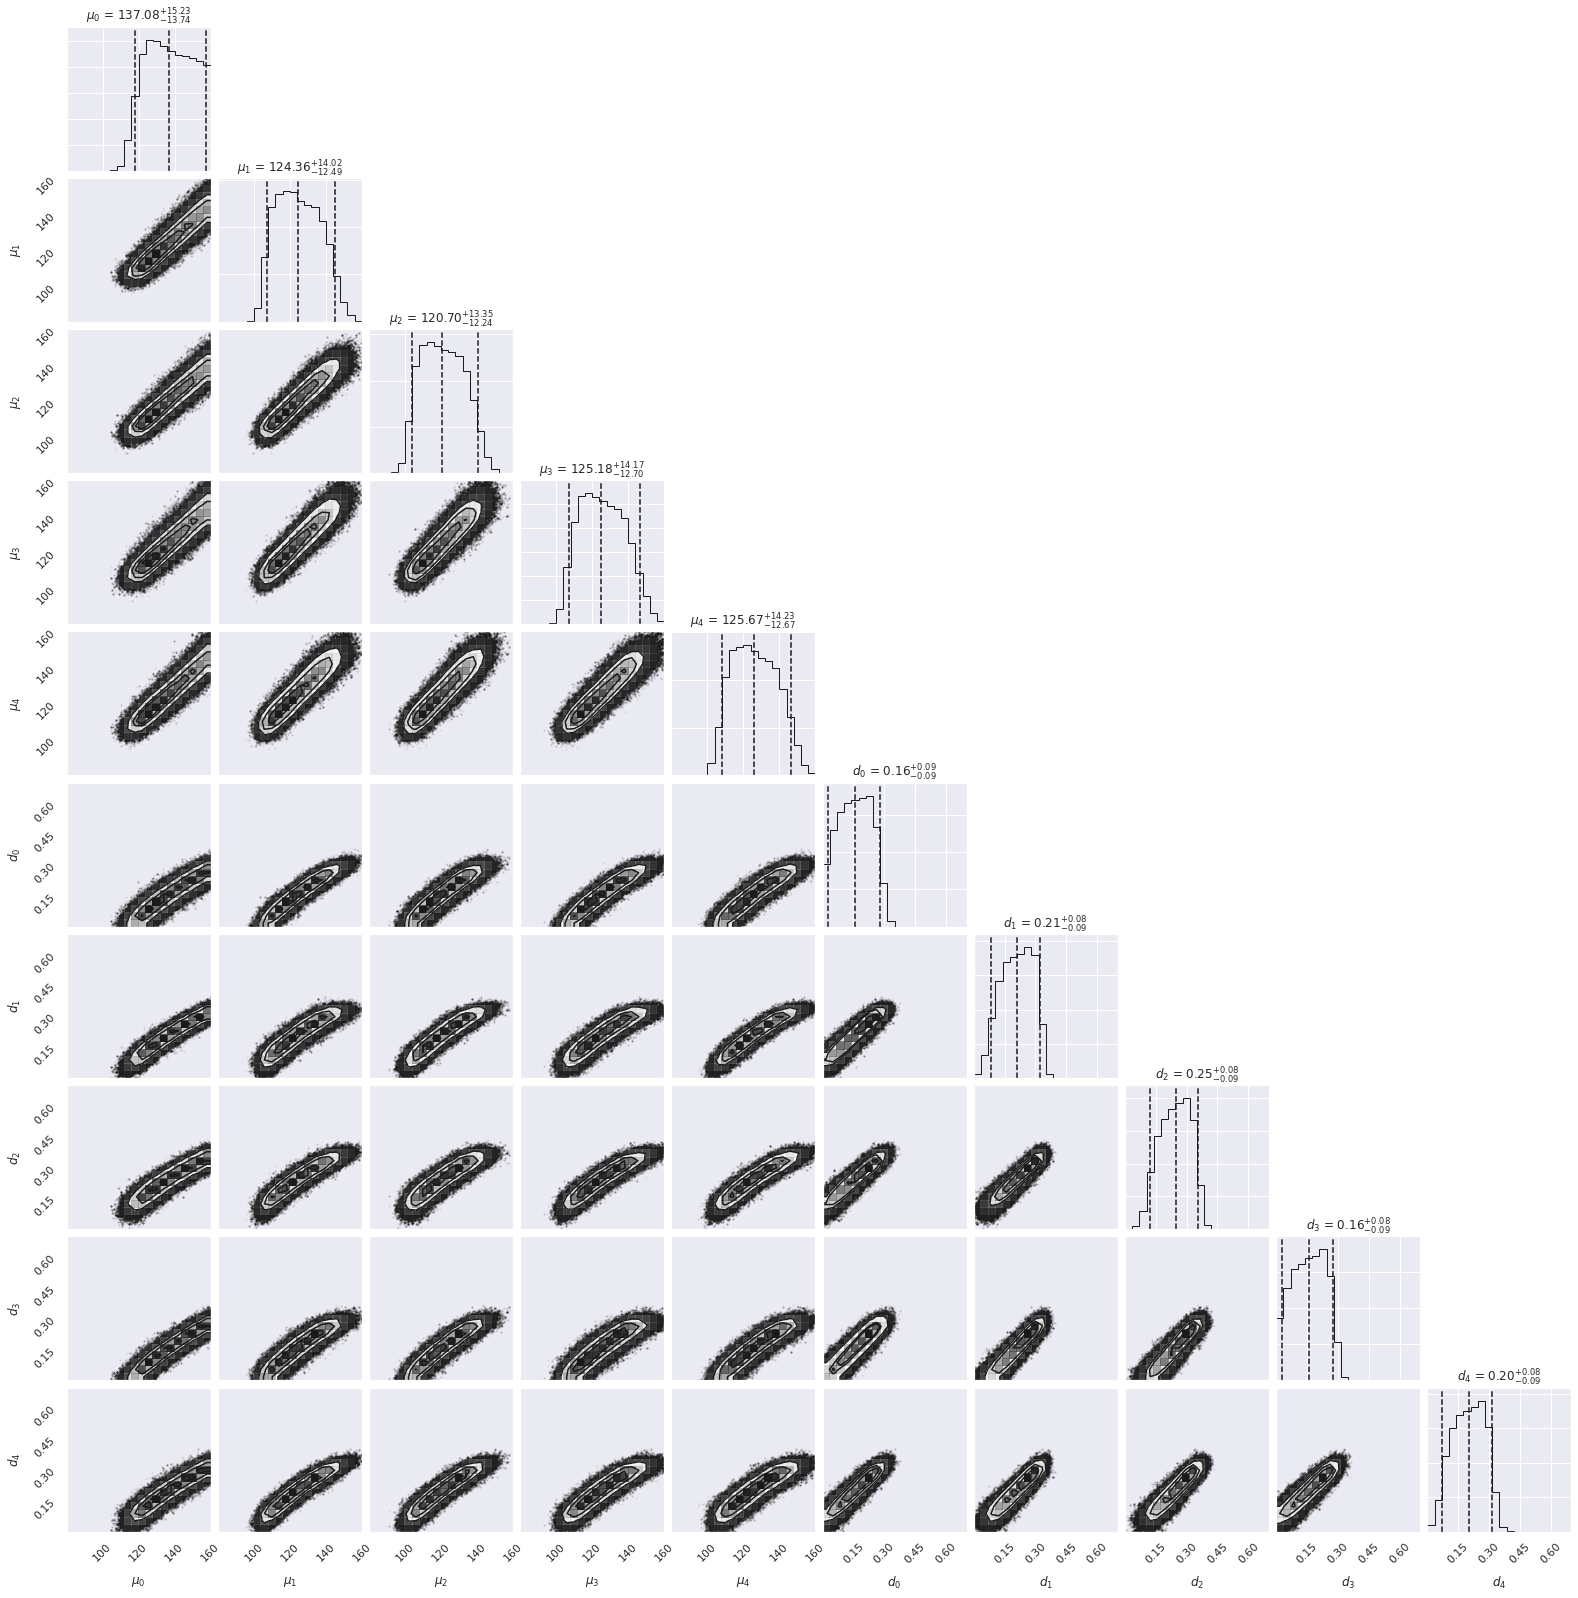

In [24]:
# make a corner plot with the posterior distribution
n_teams_plot = 5
samples_plot = samples[:, :n_teams_plot * n_parameters_per_team]

chain_labels = []
chain_range = []
for i in range(n_teams_plot):
    chain_labels.append(r'$\mu_{:}$'.format(i) )
    chain_range.append((min_score, max_score))
for i in range(n_teams_plot):
    chain_labels.append(r'$d_{:}$'.format(i) )
    chain_range.append((min_defense, max_defense))
    
fig = corner.corner(samples, 
                    labels=chain_labels, 
                    quantiles=[0.05, 0.5, 0.95],
                    show_titles=True, title_kwargs={"fontsize": 12}, 
                    range=chain_range
                   )

## To make predictions using the model for new games...
For each sample of the MCMC chain (a set of parameters) we can construct the likelihood function for the sum of their points, given the parameters, and take samples of the likelihood function $N$ times. Then, histogramming all of these samples defines the probability for the total number of points in game between the two teams. 

In [25]:
#Now, suppose we want to predict probability for the outcome of a new game...
def predict_game_outcome(samples, team_a_idx, team_b_idx, n_draws):

    mu_a_chain = np.take(samples, team_a_idx, axis=1)
    mu_b_chain = np.take(samples, team_b_idx, axis=1)

    d_a_chain = np.take(samples, n_teams + team_a_idx, axis=1)
    d_b_chain = np.take(samples, n_teams + team_b_idx, axis=1)

    mu_eff_chain = mu_a_chain * ( np.ones_like(mu_a_chain) - d_b_chain ) \
                    + mu_b_chain * ( np.ones_like(mu_b_chain) - d_a_chain )
    
    
    #for each sample mu_eff, draw from a poisson distribution with mean mu_eff
    tot_pts = np.array( [ poisson.rvs(mu, size=n_draws) for mu in mu_eff_chain ] ) 
    return tot_pts.flatten()

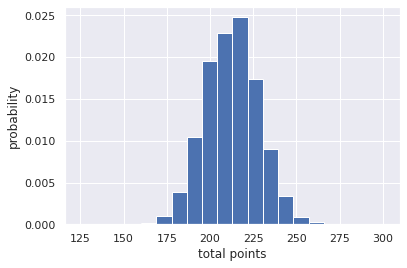

In [65]:
tot_pts = predict_game_outcome(samples=samples, team_a_idx=0, team_b_idx=1, n_draws=100)
plt.hist(tot_pts, density=True, bins=20)
plt.xlabel('total points')
plt.ylabel('probability')
plt.show()

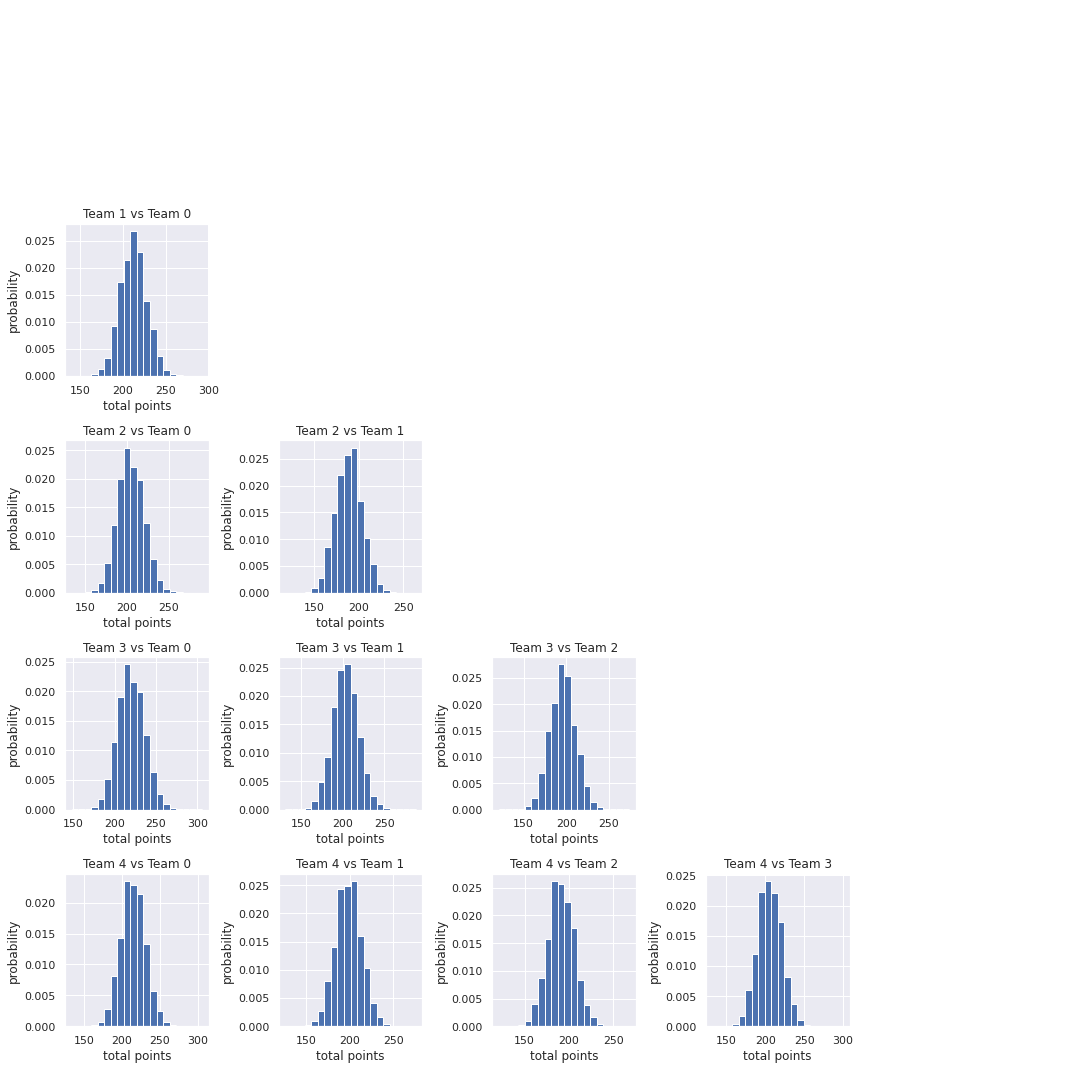

In [29]:
fig, axes = plt.subplots(n_teams, n_teams, figsize=(3*n_teams, 3*n_teams) )

thin = 10
samples_thin = samples[::thin, :] # to make predictions faster

for team_a in range(n_teams):
    for team_b in range(0, team_a):
        if team_b == team_a:
            axes[team_a, team_b].axis('off')
        else:
            tot_pts = predict_game_outcome(samples=samples_thin, 
                                           team_a_idx=team_a, team_b_idx=team_b, n_draws=100)
            axes[team_a, team_b].hist(tot_pts, density=True, bins=20)
            axes[team_a, team_b].set_xlabel('total points')
            axes[team_a, team_b].set_ylabel('probability')
            axes[team_a, team_b].set_title('Team ' + str(team_a) + ' vs Team ' + str(team_b) )
    for team_b in range(team_a, n_teams):
        axes[team_a, team_b].axis('off')
        
plt.tight_layout(True)
plt.show()